In [1]:
import sys; sys.path.append(2*'../')

import os
import glob
from pathlib import Path
from omegaconf import DictConfig
import yaml

import torch
import lightning as L

from rl4co.tasks.rl4co import RL4COLitModule


/home/botu/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


In [2]:
checkpoints_path = Path('../../saved_checkpoints/')

exp_name = 'tsp50'
model_name = 'am-tsp50'
checkpoints_path = checkpoints_path / exp_name / model_name

hydra_config_path = checkpoints_path / 'config.yaml'

with open(hydra_config_path, 'r') as stream:
    hydra_config_yaml = yaml.safe_load(stream)


# for each key in hydr_config_yaml, replace / by .
def clean_hydra_config(config, keep_value_only=True):
    """Clean hydra config by nesting dictionary and cleaning values"""
    new_config = {}
    # Iterate over config dictionary
    for key, value in config.items():
        # If key contains slash, split it and create nested dictionary recursively
        if '/' in key:
            keys = key.split('/')
            d = new_config
            for k in keys[:-1]:
                d = d.setdefault(k, {})
            d[keys[-1]] = value['value'] if keep_value_only else value
        else:
            new_config[key] = value['value'] if keep_value_only else value
    return DictConfig(new_config)


# Remove keys containing 'wandb' 
def remove_wandb_keys(config):
    """Remove keys containing 'wandb'"""
    new_config = {}
    for key, value in config.items():
        if 'wandb' in key:
            continue
        else:
            new_config[key] = value
    return new_config

hydra_config_yaml = remove_wandb_keys(hydra_config_yaml)

hydra_config = clean_hydra_config(hydra_config_yaml)
print(hydra_config)

{'model': {'_target_': 'rl4co.models.AttentionModel', 'baseline': {'_target_': 'rl4co.models.rl.reinforce.baselines.WarmupBaseline', 'baseline': {'_target_': 'rl4co.models.rl.reinforce.baselines.RolloutBaseline'}}, 'params': {'total': 708608, 'trainable': 708608, 'non_trainable': 0}}, 'data': {'batch_size': 512, 'train_size': 1280000, 'val_size': 10000}, 'trainer': {'_target_': 'lightning.pytorch.trainer.Trainer', 'default_root_dir': '/mnt/HDD/botu/botu/Dev/rl4co/logs/train/runs/tsp50/am-tsp50/2023-06-01_04-37-26', 'gradient_clip_val': 1.0, 'accelerator': 'gpu', 'precision': '16-mixed', 'strategy': {'_target_': 'lightning.pytorch.strategies.DDPStrategy', 'find_unused_parameters': True, 'gradient_as_bucket_view': True}, 'check_val_every_n_epoch': 1, 'deterministic': False, 'reload_dataloaders_every_n_epochs': 1, 'max_epochs': 100, 'devices': [1]}, 'callbacks': {'model_checkpoint': {'_target_': 'lightning.pytorch.callbacks.ModelCheckpoint', 'dirpath': '/mnt/HDD/botu/botu/Dev/rl4co/logs/t

In [3]:
lit_module = RL4COLitModule(hydra_config)


# Remove setup function from lit_module.model if hasattr(lit_module.model, 'setup')
if hasattr(lit_module.model, 'setup'):
    print("No setup function for model required during testing!")
    lit_module.model.setup = lambda *args, **kwargs: None
if hasattr(lit_module.model, "wrap_dataset"):
    print("No wrap_dataset function for model required during testing!")
    lit_module.model.wrap_dataset = lambda *args, **kwargs: None

# Load from checkpoint. We do not want to load the baseline weights, so we set strict=False
# lit_module.load_from_checkpoint(checkpoints_path / 'epoch_099.ckpt', strict=False)

def load_policy_state_dict(lit_module, path, device='cpu'):
    state_dict = torch.load(path, map_location=device)['state_dict']
    # get only policy parameters
    policy_state_dict = {k: v for k, v in state_dict.items() if 'policy' in k}
    # remove leading 'policy.' from keys
    policy_state_dict = {k.replace('model.policy.', ''): v for k, v in policy_state_dict.items()}
    
    lit_module.model.policy.load_state_dict(policy_state_dict)
    return lit_module


# Generate few training data during setup for fast loading, since not needed
lit_module.train_size = 100 
lit_module = load_policy_state_dict(lit_module, checkpoints_path / 'epoch_099.ckpt')

lit_module.setup('test')

Unused kwargs: {'params': {'total': 708608, 'trainable': 708608, 'non_trainable': 0}}


No setup function for model required during testing!
No wrap_dataset function for model required during testing!


In [35]:
state_dict = torch.load(checkpoints_path / 'epoch_099.ckpt', map_location='cpu')


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

policy = lit_module.model.policy.to(device)
policy.eval()
env = lit_module.model.env

# dataloader = lit_module.test_dataloader()

In [5]:
test_dataset = lit_module.test_dataset
dataloader = lit_module._dataloader(test_dataset, batch_size=512)

with torch.no_grad():

    rewards = []

    for batch in dataloader:
        td = batch.to(device).clone()
        td = env.reset(td)
        out = policy(td, decode_type="greedy")
        rewards.append(out['reward'])

    rewards = torch.cat(rewards)
    print(rewards.mean())

tensor(-5.7785, device='cuda:0')


In [32]:
from tqdm.auto import tqdm
from rl4co.models.zoo.symnco.augmentations import StateAugmentation as StateAugmentationN
from rl4co.models.zoo.pomo.augmentations import StateAugmentation as StateAugmentation8
from rl4co.utils.ops import batchify, unbatchify, gather_by_index


class EvalBase:
    name = "base"
    def __init__(self, env, progress=True, **kwargs):
        self.env = env
        self.progress = progress

    def __call__(self, policy, dataloader, **kwargs):

        # Collect timings for evaluation (more accurate than timeit)
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()

        with torch.no_grad():
            rewards_list = []
            actions_list = []

            for batch in tqdm(dataloader, disable=not self.progress, desc=f"Running {self.name}"):
                td = batch.to(next(policy.parameters()).device)
                td = env.reset(td)
                actions, rewards = self._inner(policy, td, **kwargs)
                rewards_list.append(rewards)
                actions_list.append(actions)

            rewards = torch.cat(rewards_list)
            actions = torch.cat(actions_list)


        end_event.record()
        torch.cuda.synchronize()
        inference_time = start_event.elapsed_time(end_event)


        tqdm.write(f"Mean reward for {self.name}: {rewards.mean():.4f}")
        tqdm.write(f"Time: {inference_time/1000:.4f}s")

        # Empty cache
        torch.cuda.empty_cache()

        return {"actions": actions, "rewards": rewards, "inference_time": inference_time, "avg_reward": rewards.mean()}

    def _inner(self, policy, td):
        raise NotImplementedError("Implement in subclass")


class GreedyEval(EvalBase):
    """Evaluates the policy using greedy decoding and single trajectory"""

    name = "greedy"
    def __init__(self, env, **kwargs):
        super().__init__(env)

    def _inner(self, policy, td):
        out = policy(td.clone(), decode_type="greedy", num_starts=0, return_actions=True)
        rewards = self.env.get_reward(td, out['actions'])
        return out['actions'], rewards


class AugmentationEval(EvalBase):
    """Evaluates the policy via N state augmentations
    If force_dihedral is True, then use 8 state augmentations (rotations and flips) as in POMO
    """

    name = "augmentation"
    def __init__(self, env, num_augment=8, force_dihedral=False, **kwargs):
        super().__init__(env)
        if num_augment == 8 and not force_dihedral:
            self.augmentation = StateAugmentation8(env.name, num_augment=num_augment)
        else:
            self.augmentation = StateAugmentationN(env.name, num_augment=num_augment, normalize=True)

    def _inner(self, policy, td, num_augment=None):
        if num_augment is None:
            num_augment = self.augmentation.num_augment
        td_init = td.clone()
        td = self.augmentation(td, num_augment=num_augment)
        out = policy(td.clone(), decode_type="greedy", num_starts=0, return_actions=True)
        
        # Move into batches and compute rewards
        rewards = self.env.get_reward(batchify(td_init, num_augment), out['actions'])
        rewards = unbatchify(rewards, num_augment)
        actions = unbatchify(out['actions'], num_augment)
        
        # Get best reward and corresponding action
        rewards, max_idxs = rewards.max(dim=1)
        actions = gather_by_index(actions, max_idxs, dim=1)
        return actions, rewards
    

class SamplingEval(EvalBase):
    """Evaluates the policy via N samples from the policy"""

    name = "sampling"
    def __init__(self, env, samples, softmax_temp=None, **kwargs):
        super().__init__(env)
        self.samples = samples
        self.softmax_temp = softmax_temp

    def _inner(self, policy, td):
        td = batchify(td, self.samples)
        out = policy(td.clone(), decode_type="sampling", 
                             num_starts=0, return_actions=True, 
                             softmax_temp=self.softmax_temp)
        
        # Move into batches and compute rewards
        rewards = self.env.get_reward(td, out['actions'])
        rewards = unbatchify(rewards, self.samples)
        actions = unbatchify(out['actions'], self.samples)
        
        # Get the best reward and action for each sample
        rewards, max_idxs = rewards.max(dim=1)
        actions = gather_by_index(actions, max_idxs, dim=1)
        return actions, rewards


class GreedyMultiStartEval(EvalBase):
    """Evaluates the policy via `num_starts` greedy multistarts samples from the policy"""

    name = "greedy_multistart"
    def __init__(self, env, num_starts, **kwargs):
        super().__init__(env)
        self.num_starts = num_starts

    def _inner(self, policy, td):
        td_init = td.clone()
        out = policy(td.clone(), decode_type="greedy_multistart",
                             num_starts=self.num_starts, return_actions=True)
        
        # Move into batches and compute rewards
        td = batchify(td_init, self.num_starts)
        rewards = self.env.get_reward(td, out['actions'])
        rewards = unbatchify(rewards, self.num_starts)
        actions = unbatchify(out['actions'], self.num_starts)
        
        # Get the best trajectories
        rewards, max_idxs = rewards.max(dim=1)
        actions = gather_by_index(actions, max_idxs, dim=1)
        return actions, rewards
    

class GreedyMultiStartAugmentEval(EvalBase):
    """Evaluates the policy via `num_starts` samples from the policy 
    and `num_augment` augmentations of each sample.`"""

    name = "greedy_multistart_augment"
    def __init__(self, env, num_starts, num_augment=8, force_sym_augment=False, **kwargs):
        super().__init__(env)
        self.num_starts = num_starts
        if num_augment == 8 and not force_sym_augment:
            self.augmentation = StateAugmentation8(env.name, num_augment=num_augment)
        else:
            self.augmentation = StateAugmentationN(env.name, num_augment=num_augment)
            
    def _inner(self, policy, td, num_augment=None):
        if num_augment is None:
            num_augment = self.augmentation.num_augment
        
        td_init = td.clone()

        td = self.augmentation(td, num_augment=num_augment)
        out = policy(td.clone(), decode_type="greedy_multistart",
                             num_starts=self.num_starts, return_actions=True)

        # Move into batches and compute rewards
        td = batchify(td_init, (num_augment, self.num_starts))
        rewards = self.env.get_reward(td, out['actions'])
        rewards = unbatchify(rewards, self.num_starts * num_augment)
        actions = unbatchify(out['actions'], self.num_starts * num_augment)

        # Get the best trajectories
        rewards, max_idxs = rewards.max(dim=1)
        actions = gather_by_index(actions, max_idxs, dim=1)

        return actions, rewards

In [33]:
dataset = lit_module.test_dataset
dataloader_func = lit_module._dataloader


# eval_fn = GreedyMultiStartEval(env, num_starts=env.num_loc) #, num_augment=8)
eval_fn = GreedyMultiStartAugmentEval(env, num_starts=env.num_loc, num_augment=8)


# eval_fn = AugmentationEval(env, num_augment=8)
dataloader = dataloader_func(dataset, batch_size=128)
ret_vals_greedy = eval_fn(policy, dataloader)

Running greedy_multistart_augment:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for greedy_multistart_augment: -5.7115
Time: 17.4570s


In [ ]:
# def get_optimal_batch_size()

In [8]:
# Evaluation settings 
eval_settings = {
    "greedy": {"func": GreedyEval, "kwargs": {}, "batch_size": 2048},
    "augmentation": {"func": AugmentationEval, "kwargs": {"num_augment": 8}, "batch_size": 128},
    "sampling": {"func": SamplingEval, "kwargs": {"samples": 8, "softmax_temp": None}, "batch_size": 128},
    "greedy_multistart": {"func": GreedyMultiStartEval, "kwargs": {"num_starts": env.num_loc}, "batch_size": 128},
    "greedy_multistart_augment": {"func": GreedyMultiStartAugmentEval, "kwargs": {"num_starts": env.num_loc, "num_augment": 8}, "batch_size": 4},
}

In [37]:
# from collections import defaultdict

# dataset = lit_module.test_dataset
# dataloader_func = lit_module._dataloader

# # Statistics collection
# stats = defaultdict(list)

# # Run greedy
# for eval_name, eval_setting in eval_settings.items():
#     func, kwargs, batch_size = eval_setting["func"], eval_setting["kwargs"], eval_setting["batch_size"]
#     eval_fn = func(env, **kwargs)
#     ret_vals = eval_fn(policy, dataloader_func(dataset, batch_size=batch_size))

#     # Collect statistics
#     stats[eval_name].append(
#         {
#             "avg_reward": ret_vals["avg_reward"].detach().cpu().item(),
#             "args": kwargs,
#         }
#     )

In [3]:
a = {'b': 1, 'c': 2}

# example of update
a.update({'b': 3, 'd': 4})
print(a)

{'b': 3, 'c': 2, 'd': 4}


In [10]:
import itertools
from collections import defaultdict

# Statistics collection
stats = defaultdict(list)

# Experiment settings

experiments = {
    "greedy": {},
    "augmentation": {"num_augment": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]},
    "augmentation_8": {"num_augment": 8, "force_dihedral": True},
    "sampling": {"samples": [2, 4, 8, 16, 32, 64, 128], "softmax_temp": [0.1, 0.5, 1.0, 1.5]},
    "greedy_multistart": {"num_starts": env.num_loc},
    "greedy_multistart_augment_dihedral": {"num_starts": env.num_loc, "num_augment": 8, "force_dihedral": True},
    "greedy_multistart_augment": {"num_starts": env.num_loc, "num_augment": [2, 4, 8, 16]},
}


experiments = {
    {"name": "Greedy", "base": "greedy", "kwargs": {}},
    {"name": "Symmetric Augmentation", "base": "augmentation", "kwargs": {"num_augment": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}},
    {"name": "Dihedral Augmentation (x8)", "base": "augmentation", "kwargs": {"num_augment": 8, "force_dihedral": True}},
    {"name": "Sampling", "base": "sampling", "kwargs": {"samples": [4, 8, 16, 32, 64, 128], "softmax_temp": [0.1, 0.5, 1.0, 1.5]}},
    {"name": "Greedy Multistart", "base": "greedy_multistart", "kwargs": {"num_starts": env.num_loc}},
    {"name": "Greedy Multistart Augment Dihedral (x8)", "base": "greedy_multistart_augment_dihedral", "kwargs": {"num_starts": env.num_loc, "num_augment": 8, "force_dihedral": True}},
    {"name": "Greedy Multistart Symmetric Augment", "base": "greedy_multistart_augment", "kwargs": {"num_starts": env.num_loc, "num_augment": [2, 4, 8, 16]}},
}


# Iterate over experiments
for exp_name, exp_kwargs in experiments.items():
    kwargs = {}
    # iterate over kwargs. If we find a list, make all possible combinations
    for k, v in exp_kwargs.items():
        if isinstance(v, list):
            kwargs[k] = v
        else:
            kwargs[k] = [v]
    # Make all combinations
    kwargs = list(itertools.product(*kwargs.values()))
    # set keys  
    kwargs = [dict(zip(exp_kwargs.keys(), k)) for k in kwargs]

    for kws_single_exp in kwargs:

        eval_setting = eval_settings[exp_name].copy()
        func, batch_size = eval_setting["func"], eval_setting["batch_size"]
        print(f"Running experiment {exp_name} with {kws_single_exp} settings")

        # Run exps
        eval_fn = func(env, **kws_single_exp)
        ret_vals = eval_fn(policy, dataloader_func(dataset, batch_size=batch_size))

        stats[exp_name].append(
        {
            "avg_reward": ret_vals["avg_reward"].detach().cpu().item(),
            "kwargs": kws_single_exp,
        }
    )

Running experiment greedy with {} settings


Running greedy:   0%|          | 0/5 [00:00<?, ?it/s]

Mean reward for greedy: -5.7785
Time: 0.6185s
Running experiment augmentation with {'num_augment': 2} settings


Running augmentation:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for augmentation: -5.7527
Time: 4.7082s
Running experiment augmentation with {'num_augment': 4} settings


Running augmentation:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for augmentation: -5.7333
Time: 4.7563s
Running experiment augmentation with {'num_augment': 8} settings


Running augmentation:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for augmentation: -5.7152
Time: 6.0354s
Running experiment augmentation with {'num_augment': 16} settings


Running augmentation:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for augmentation: -5.7121
Time: 9.0408s
Running experiment augmentation with {'num_augment': 32} settings


Running augmentation:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for augmentation: -5.7070
Time: 14.4747s
Running experiment augmentation with {'num_augment': 64} settings


Running augmentation:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for augmentation: -5.7041
Time: 25.9693s
Running experiment augmentation with {'num_augment': 128} settings


Running augmentation:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for augmentation: -5.7023
Time: 49.4243s
Running experiment sampling with {'samples': 32, 'softmax_temp': 0.1} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7700
Time: 14.9285s
Running experiment sampling with {'samples': 32, 'softmax_temp': 0.3} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7581
Time: 14.9236s
Running experiment sampling with {'samples': 32, 'softmax_temp': 0.5} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7494
Time: 14.9765s
Running experiment sampling with {'samples': 32, 'softmax_temp': 1.0} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7370
Time: 14.9951s
Running experiment sampling with {'samples': 32, 'softmax_temp': 1.5} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7317
Time: 14.9321s
Running experiment sampling with {'samples': 64, 'softmax_temp': 0.1} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7685
Time: 26.4720s
Running experiment sampling with {'samples': 64, 'softmax_temp': 0.3} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7550
Time: 26.4129s
Running experiment sampling with {'samples': 64, 'softmax_temp': 0.5} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7459
Time: 26.4626s
Running experiment sampling with {'samples': 64, 'softmax_temp': 1.0} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7327
Time: 26.4392s
Running experiment sampling with {'samples': 64, 'softmax_temp': 1.5} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7265
Time: 26.3951s
Running experiment sampling with {'samples': 128, 'softmax_temp': 0.1} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7673
Time: 49.8205s
Running experiment sampling with {'samples': 128, 'softmax_temp': 0.3} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7525
Time: 49.9221s
Running experiment sampling with {'samples': 128, 'softmax_temp': 0.5} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7428
Time: 49.9339s
Running experiment sampling with {'samples': 128, 'softmax_temp': 1.0} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7287
Time: 49.7589s
Running experiment sampling with {'samples': 128, 'softmax_temp': 1.5} settings


Running sampling:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for sampling: -5.7221
Time: 49.7157s
Running experiment greedy_multistart with {'num_starts': 50} settings


Running greedy_multistart:   0%|          | 0/79 [00:00<?, ?it/s]

Mean reward for greedy_multistart: -5.7668
Time: 6.6863s
Running experiment greedy_multistart_augment with {'num_starts': 50, 'num_augment': 2} settings


Running greedy_multistart_augment:   0%|          | 0/2500 [00:00<?, ?it/s]

Mean reward for greedy_multistart_augment: -5.7428
Time: 187.3746s
Running experiment greedy_multistart_augment with {'num_starts': 50, 'num_augment': 4} settings


Running greedy_multistart_augment:   0%|          | 0/2500 [00:00<?, ?it/s]

Mean reward for greedy_multistart_augment: -5.7256
Time: 188.3272s
Running experiment greedy_multistart_augment with {'num_starts': 50, 'num_augment': 8} settings


Running greedy_multistart_augment:   0%|          | 0/2500 [00:00<?, ?it/s]

Mean reward for greedy_multistart_augment: -5.7115
Time: 189.5428s
Running experiment greedy_multistart_augment with {'num_starts': 50, 'num_augment': 16} settings


Running greedy_multistart_augment:   0%|          | 0/2500 [00:00<?, ?it/s]

Mean reward for greedy_multistart_augment: -5.7078
Time: 189.7196s
Running experiment greedy_multistart_augment with {'num_starts': 50, 'num_augment': 32} settings


Running greedy_multistart_augment:   0%|          | 0/2500 [00:00<?, ?it/s]

Mean reward for greedy_multistart_augment: -5.7038
Time: 207.1693s


## Plotting

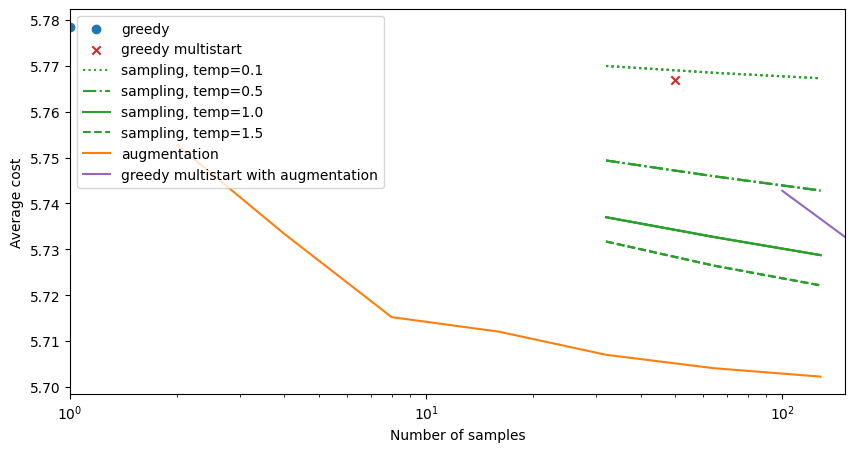

In [39]:
# collect stats
import matplotlib.pyplot as plt

# get exp names from stats
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Colors
color_scheme = {
    "greedy": "tab:blue",
    "augmentation": "tab:orange",
    "sampling": "tab:green",
    "greedy_multistart": "tab:red",
    "greedy_multistart_augment": "tab:purple",
}

linestyle_softmax_temp = {
    0.1: ":",
    # 0.3: "--",
    0.5: "-.",
    1.0: "-",
    1.5: "--",
}


# Greedy, 1 sample
greedy_stats = stats["greedy"]
reward = [s["avg_reward"] for s in greedy_stats]
ax.scatter([1], [-r for r in reward], label="greedy", color=color_scheme["greedy"])


# Greedy multistart
greedy_multistart_stats = stats["greedy_multistart"]
reward = [s["avg_reward"] for s in greedy_multistart_stats]
ax.scatter([env.num_loc], [-r for r in reward], label="greedy multistart", color=color_scheme["greedy_multistart"], marker="x")


# Sampling, N samples with different temperatures
sampling_stats = stats["sampling"]
# num_samples = [s["kwargs"]["samples"] for s in sampling_stats]
for temp in [s['kwargs']['softmax_temp'] for s in sampling_stats]:
    # if temp is 0.3, skip
    if temp == 0.3:
        continue
    reward = [s["avg_reward"] for s in sampling_stats if s['kwargs']['softmax_temp'] == temp]
    num_samples = [s["kwargs"]["samples"] for s in sampling_stats if s['kwargs']['softmax_temp'] == temp]
    ax.plot(num_samples, [-r for r in reward], label=f"sampling, temp={temp}", 
            color=color_scheme["sampling"], linestyle=linestyle_softmax_temp[temp])


# Augmentation, N samples
aug_stats = stats["augmentation"]
num_augments = [s["kwargs"]["num_augment"] for s in aug_stats]
reward = [s["avg_reward"] for s in aug_stats]
ax.plot(num_augments, [-r for r in reward], label="augmentation", color=color_scheme["augmentation"])


# Greedy multistart with augmentation
greedy_multistart_augment_stats = stats["greedy_multistart_augment"]
num_augments = [s["kwargs"]["num_augment"] for s in greedy_multistart_augment_stats]
num_samples = [a * env.num_loc for a in num_augments]
reward = [s["avg_reward"] for s in greedy_multistart_augment_stats]
ax.plot(num_samples, [-r for r in reward], label="greedy multistart with augmentation", color=color_scheme["greedy_multistart_augment"])

ax.set_xlabel("Number of samples")
ax.set_ylabel("Average cost")
  

# Invert y axis, since we want to minimize cost, and reward is negative cost
# ax.invert_yaxis()
ax.legend()

# remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# set limits for x axis
ax.set_xlim([1, 150])

# logscale on x axis
ax.set_xscale('log')